In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

gpkg_path = "C:/Users/Hp Elitebook/Desktop/python/final_data_20_24.gpkg" 
layer_name = None     

gdf = gpd.read_file(gpkg_path, layer=layer_name)

# =====================================================
# 3. Nom des régions
# =====================================================
insee_region_dict = {
    "01": "Guadeloupe",
    "02": "Martinique",
    "03": "Guyane",
    "04": "La Réunion",
    "06": "Mayotte",
    "11": "Île-de-France",
    "24": "Centre-Val de Loire",
    "27": "Bourgogne-Franche-Comté",
    "28": "Normandie",
    "32": "Hauts-de-France",
    "44": "Grand Est",
    "52": "Pays de la Loire",
    "53": "Bretagne",
    "75": "Nouvelle-Aquitaine",
    "76": "Occitanie",
    "84": "Auvergne-Rhône-Alpes",
    "93": "Provence-Alpes-Côte d'Azur",
    "94": "Corse"
}

gdf["region_name"] = gdf["code_insee_de_la_region"].map(insee_region_dict)


#### Création des variables binaires cibles

In [2]:
gdf.columns

Index(['SWI_UNIF_MENS', 'ym', 'swi_min', 'swi_mean', 'swi_max', 'prenei_sum',
       'preliq_sum', 'pe_sum', 'evap_sum', 't_avg', 'ff_avg', 'q_avg',
       'hu_avg', 'dli_avg', 'ssi_avg', 'etp_avg', 'tinf_avg', 'tsup_avg',
       'resr_neige_avg', 'resr_neige6_avg', 'hteurneige_avg',
       'hteurneige6_avg', 'hteurneigex_avg', 'snow_frac_avg', 'drainc_sum',
       'runc_sum', 'ecoulement_sum', 'wg_racine_avg', 'wgi_racine_avg', 'ALEA',
       'NIVEAU', 'index__adm', 'cleabs', 'nom_officiel',
       'nom_officiel_en_majuscules', 'numero_du_canton', 'code_insee',
       'codes_insee_des_arrondissements', 'code_insee_du_departement',
       'code_insee_de_la_region', 'composition_du_canton', 'geometry',
       'region_name'],
      dtype='object')

#### Reg logistique pour quantile 25%

In [3]:
# -------------------------------
# 1. Charger les données
# -------------------------------

# Assurer que 'ym' est au format datetime
gdf['ym'] = pd.to_datetime(gdf['ym'])
gdf['annee'] = gdf['ym'].dt.year
gdf['mois'] = gdf['ym'].dt.month
gdf['trimestre'] = ((gdf['mois'] - 1) // 3 + 1).astype(int)

# -------------------------------
# 2. Séparer train (2020-2023) et test (2024)
# -------------------------------
train_gdf = gdf[gdf['annee'].between(2020, 2023)].copy()
test_gdf = gdf[gdf['annee'] == 2024].copy()

# -------------------------------
# 3. Calcul du Q25 par commune et trimestre
# -------------------------------
q25_table = train_gdf.groupby(['code_insee', 'trimestre'])['SWI_UNIF_MENS'].quantile(0.25).reset_index()
q25_table = q25_table.rename(columns={'SWI_UNIF_MENS': 'SWI_Q25'})

# -------------------------------
# 4. Associer le Q25 à tous les points
# -------------------------------
train_gdf = train_gdf.merge(q25_table, on=['code_insee', 'trimestre'], how='left')
test_gdf = test_gdf.merge(q25_table, on=['code_insee', 'trimestre'], how='left')

# -------------------------------
# 5. Créer variable binaire sécheresse
# -------------------------------
train_gdf['secheresse'] = (train_gdf['SWI_UNIF_MENS'] < train_gdf['SWI_Q25']).astype(int)
test_gdf['secheresse'] = (test_gdf['SWI_UNIF_MENS'] < test_gdf['SWI_Q25']).astype(int)

# -------------------------------
# 6. Préparer les variables explicatives
# -------------------------------
nf = ['SWI_UNIF_MENS', 'swi_min', 'swi_mean', 'swi_max', 'prenei_sum',
            'preliq_sum', 'pe_sum', 'evap_sum', 't_avg', 'ff_avg', 'q_avg',
            'hu_avg', 'dli_avg', 'ssi_avg', 'etp_avg', 'tinf_avg', 'tsup_avg',
            'resr_neige_avg', 'resr_neige6_avg', 'hteurneige_avg',
            'hteurneige6_avg', 'hteurneigex_avg', 'snow_frac_avg', 'drainc_sum',
            'runc_sum', 'ecoulement_sum', 'wg_racine_avg', 'wgi_racine_avg']


categorical_features = ["ALEA", "region_name"]

features = nf + categorical_features

X_train = train_gdf[features]
y_train = train_gdf['secheresse']

X_test = test_gdf[features]
y_test = test_gdf['secheresse']


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nf),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Créer le pipeline complet
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)


##### Evaluation

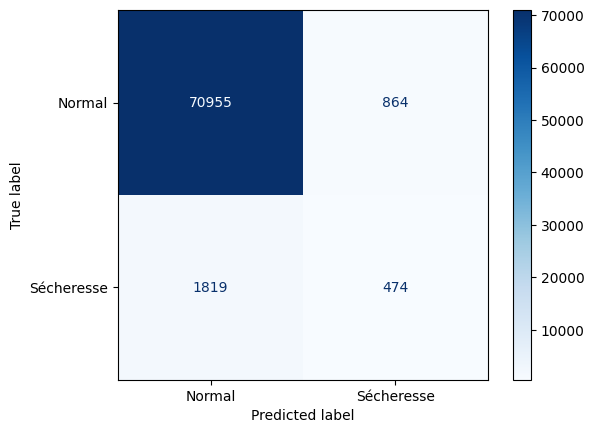

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Sécheresse"]
)

disp.plot(cmap="Blues")


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Rapport complet
print("\nClassification report :\n")
print(classification_report(y_test, y_pred))


Classification report :

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     71819
           1       0.35      0.21      0.26      2293

    accuracy                           0.96     74112
   macro avg       0.66      0.60      0.62     74112
weighted avg       0.96      0.96      0.96     74112



#### Reg pour Q05

In [7]:
# -------------------------------
# 1. Charger les données
# -------------------------------
# gdf = gpd.read_file("data_swi.gpkg")  # adapter selon ton fichier
# Assurer que 'ym' est au format datetime
gdf['ym'] = pd.to_datetime(gdf['ym'])
gdf['annee'] = gdf['ym'].dt.year
gdf['mois'] = gdf['ym'].dt.month
gdf['trimestre'] = ((gdf['mois'] - 1) // 3 + 1).astype(int)

# -------------------------------
# 2. Séparer train (2020-2023) et test (2024)
# -------------------------------
train_gdf = gdf[gdf['annee'].between(2020, 2023)].copy()
test_gdf = gdf[gdf['annee'] == 2024].copy()

# -------------------------------
# 3. Calcul du Q05 par commune et trimestre
# -------------------------------
q05_table = train_gdf.groupby(['code_insee', 'trimestre'])['SWI_UNIF_MENS'].quantile(0.05).reset_index()
q05_table = q05_table.rename(columns={'SWI_UNIF_MENS': 'SWI_Q05'})

# -------------------------------
# 4. Associer le Q05 à tous les points
# -------------------------------
train_gdf = train_gdf.merge(q05_table, on=['code_insee', 'trimestre'], how='left')
test_gdf = test_gdf.merge(q05_table, on=['code_insee', 'trimestre'], how='left')

# -------------------------------
# 5. Créer variable binaire sécheresse
# -------------------------------
train_gdf['secheresse'] = (train_gdf['SWI_UNIF_MENS'] < train_gdf['SWI_Q05']).astype(int)
test_gdf['secheresse'] = (test_gdf['SWI_UNIF_MENS'] < test_gdf['SWI_Q05']).astype(int)

# -------------------------------
# 6. Préparer les variables explicatives
# -------------------------------
nf = ['SWI_UNIF_MENS', 'swi_min', 'swi_mean', 'swi_max', 'prenei_sum',
            'preliq_sum', 'pe_sum', 'evap_sum', 't_avg', 'ff_avg', 'q_avg',
            'hu_avg', 'dli_avg', 'ssi_avg', 'etp_avg', 'tinf_avg', 'tsup_avg',
            'resr_neige_avg', 'resr_neige6_avg', 'hteurneige_avg',
            'hteurneige6_avg', 'hteurneigex_avg', 'snow_frac_avg', 'drainc_sum',
            'runc_sum', 'ecoulement_sum', 'wg_racine_avg', 'wgi_racine_avg']


categorical_features = ["ALEA", "region_name"]

features = nf + categorical_features

X_train = train_gdf[features]
y_train = train_gdf['secheresse']

X_test = test_gdf[features]
y_test = test_gdf['secheresse']


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nf),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

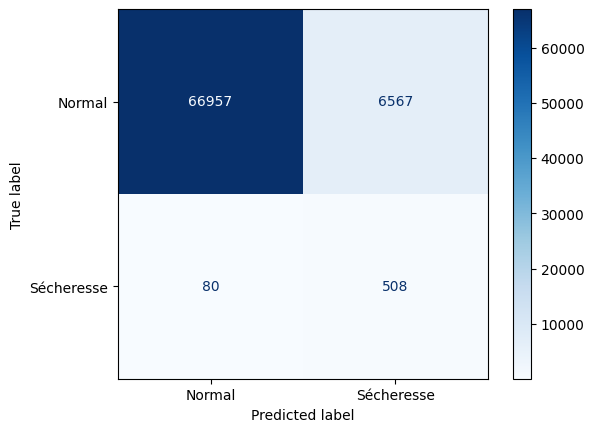

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Sécheresse"]
)

disp.plot(cmap="Blues")


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Rapport complet
print("\nClassification report :\n")
print(classification_report(y_test, y_pred))


Classification report :

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     73524
           1       0.07      0.86      0.13       588

    accuracy                           0.91     74112
   macro avg       0.54      0.89      0.54     74112
weighted avg       0.99      0.91      0.95     74112

